In [1]:
!pip install openpyxl
!pip install lifelines
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test
import datetime
import math
import statistics
import matplotlib.cm as cm

  Using cached lifelines-0.29.0-py3-none-any.whl (349 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
  Using cached autograd-1.7.0-py3-none-any.whl (52 kB)
  Using cached autograd_gamma-0.5.0-py3-none-any.whl
  Using cached formulaic-1.0.2-py3-none-any.whl (94 kB)
  Using cached interface_meta-1.3.0-py3-none-any.whl (14 kB)
  Using cached wrapt-1.16.0-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (80 kB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allensdk 2.16.2 requires pandas==1.5.3, but you have pandas 2.2.3 which is incompatible.


/tmp/ipykernel_1509/4176339480.py:320: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('magma', len(GCohorts))  # Using 'magma' colormap


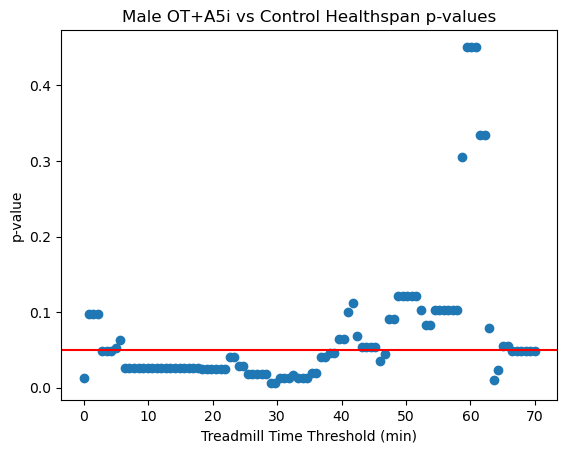

Male OT+A5i vs Control max significant FI value = 70.0 and min significant FI value = 0.0


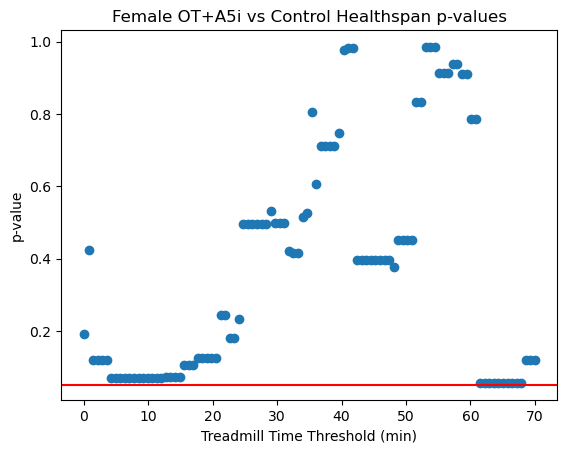

No significant FI values


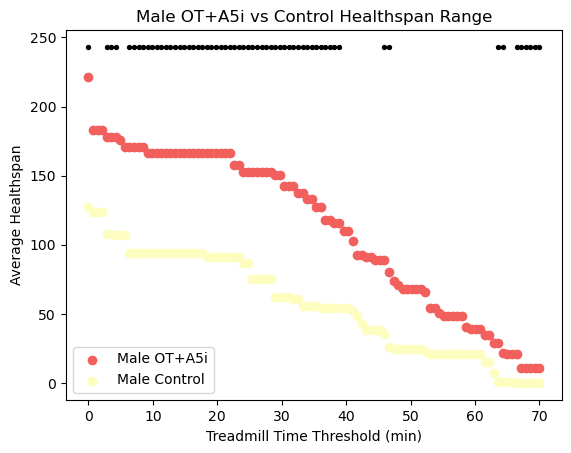

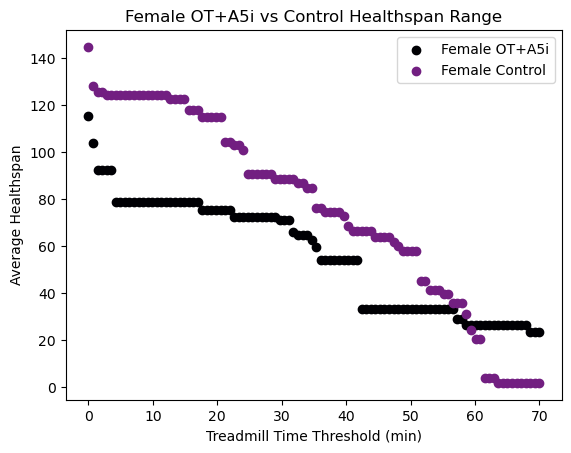

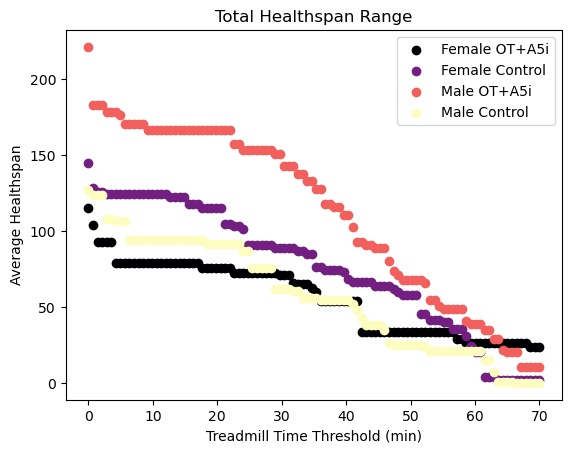

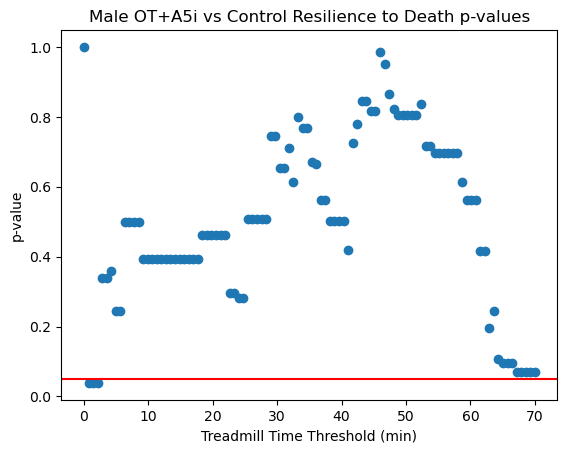

Male OT+A5i vs Control max significant FI value = 2.1212121212121247 and min significant FI value = 0.707070707070713


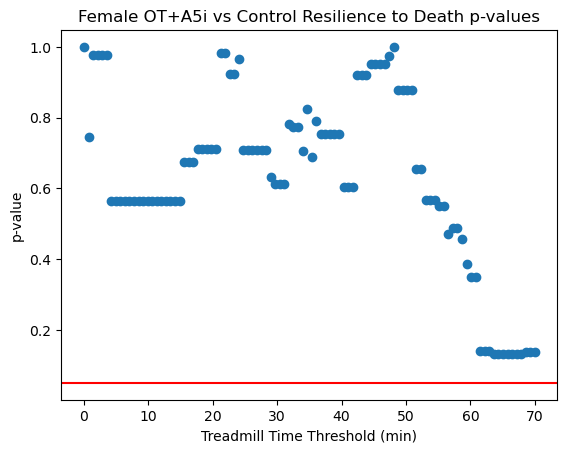

No significant FI values


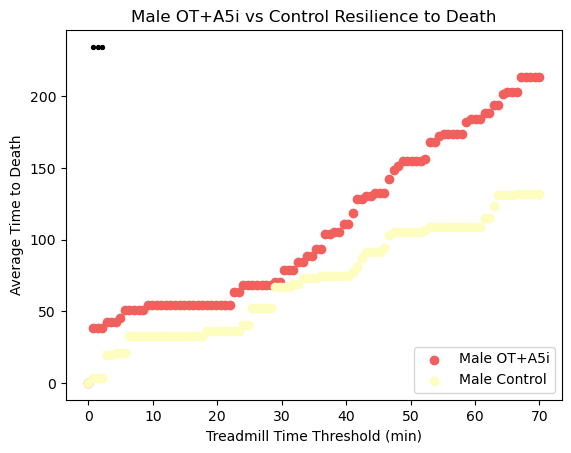

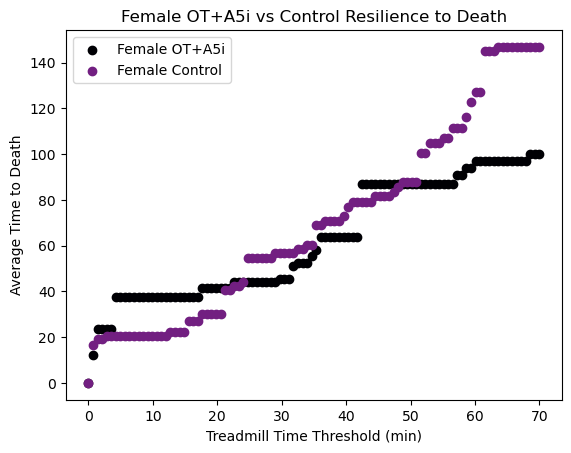

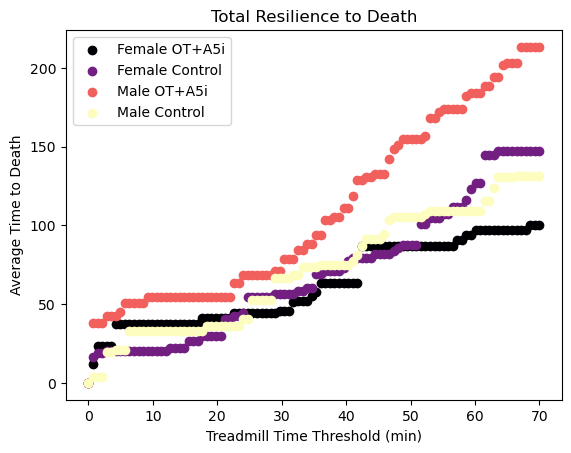

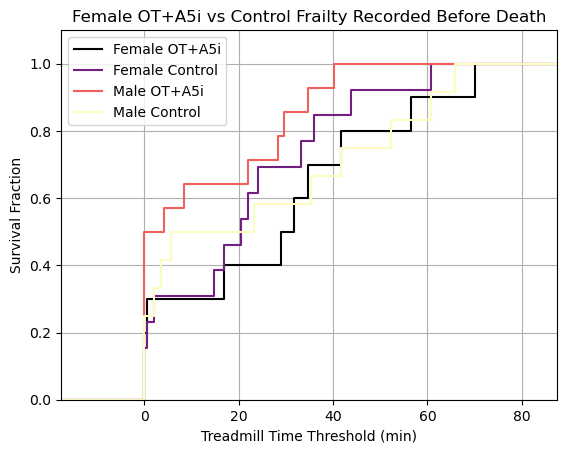

FOA N = 10
FCL N = 13
MOA N = 14
MCL N = 12


In [3]:
#Set higherisfrail = 1 if true, and div_facor = 2 for frailty index since we initially multiplied by 2
#For least and most frail, assume all numbers have already been divided by div_factor, so set most = 1 for FI
#Remove 0s removes mice that started the experiment already below the threshold and therefore had a healthspan of 0. Makes graphs looks wonky though because it removes them, causing a discontinuos appearance.
#Default is not normalized, not removing 0s
#Add_todays_date sets all Nan dates to the current date. Used if you need to calcuate the healthspan graphs before the study is over

#Hang Test, Treadmill, Overall Frailty Index, NOR Overall Discrimination Inde
#Frailty Index Threshold, Hang Test Time Threshold (sec), Treadmill Time Threshold (min), NOR Discrimination Index Threshold

#'Male XBP1s vs OTA5i': ['MXOA', 'MXCL'], 'Female XBP1s vs OT+A5i': ['FXOA','FXCL'], 'Male XBP1s vs Control': ['MXCL','MCL'], 'Female XBP1s vs Control': ['FXCL','FCL']
#{'Male OT+A5i vs Control': ['MOA','MCL'], 'Female OT+A5i vs Control': ['FOA','FCL']}

df = pd.read_excel (r'Master 10.8.24.xlsx', sheet_name='Treadmill', header = None)
dt = pd.read_excel (r'Dates 10.8.24.xlsx', sheet_name='Dates', header = None)
div_factor = 1
Xaxis = 'Treadmill Time Threshold (min)'
Test_Cohorts = {'Male OT+A5i vs Control': ['MOA','MCL'], 'Female OT+A5i vs Control': ['FOA','FCL']}

Least_Frail = 70
Most_Frail = 0
Steps = 100

Manual_colors = 1
Healthspan_legend = 1
Death_resilience_legend = 1
Frailty_before_death_legend = 1
Normalized = 0
remove_0s = 0
add_todays_date = 0
color_dict = {'MOA': [0.12156863, 0.46666667, 0.70588235, 1.        ], 'MCL': [1.        , 0.49803922, 0.05490196, 1.        ], 'FOA': [0.17254902, 0.62745098, 0.17254902, 1.        ], 'FCL': [0.58039216, 0.40392157, 0.74117647, 1.        ], 'MXOA': [0.54901961, 0.3372549 , 0.29411765, 1.        ], 'MXCL': [0.49803922, 0.49803922, 0.49803922, 1.        ], 'FXOA': [0.7372549 , 0.74117647, 0.13333333, 1.        ], 'FXCL': [0.09019608, 0.74509804, 0.81176471, 1.        ]}
#color_dict = {'MS': [0.12156863, 0.46666667, 0.70588235, 1.        ], 'MCS': [1.        , 0.49803922, 0.05490196, 1.        ], 'FS': [0.17254902, 0.62745098, 0.17254902, 1.        ], 'FCS': [0.58039216, 0.40392157, 0.74117647, 1.        ], 'MHA': [0.54901961, 0.3372549 , 0.29411765, 1.        ], 'FHA': [0.49803922, 0.49803922, 0.49803922, 1.        ]}


if Most_Frail > Least_Frail:
    higherisfrail = 1
else:
    higherisfrail = 0

GCohorts = []
for sublist in list(Test_Cohorts.values()):
    GCohorts.extend(sublist)
GCohorts = list(set(GCohorts))

#Creating ID and Cohort lists
M_ID = df.iloc[1:,:1]
Cohort = dt.iloc[1:,1:3]
Sex = dt.iloc[1:,1:2]
Comb_Cohort = Cohort[1] + Cohort[2]
Cohort = Comb_Cohort.values.tolist()
df = df.iloc[:,1:]

DOB = dt.iloc[1:,5:6]
DOD = dt.iloc[1:,4:5]
DOI = dt.iloc[1:,6:7]
M_ID = M_ID[0].tolist()
DOB = DOB[5].tolist()
DOD = DOD[4].tolist()
DOI = DOI[6].tolist()

#Below calculates initial mean for the normalized healthspan graph. Will need to determine new way to calc for mice that didn't start in m0. For now I'm removing it since it interferes with the code with mice that dont start at m0.
#month_0 = df.iloc[1:,:1]
#month_0 = month_0.values.tolist()
#total = 0
#for i in month_0:
#    total = total+i[0]
#initial_mean = total/len(month_0)

#Creates function to return date of events
def map_date(date_point):
    if isinstance(date_point, datetime.datetime):
        return date_point.strftime('%m/%d/%Y')
    else:
        return date_point
#    if isinstance(date_point, str):
#        return date_point
#    return date_point.strftime('%m/%d/%Y')
test_file = df.values.tolist()
death_dates = DOD
if add_todays_date == 1:
    current_date = datetime.datetime.today()
    death_dates = [current_date if pd.isna(date) else date for date in death_dates]
dates = test_file.pop(0)
count = 0

#add indicator or death date or month 0 here
#below simply creates list of which month the threshold is reached
def healthspan_calc(threshold, normalized, remove_0s):
    healthspan = []
    notes = []
    healthspan_dates = []
    if normalized == 1:
        norm_factor = initial_mean
    elif normalized == 0:
        norm_factor = 1
    for i in range(len(test_file)):
        mouse = test_file[i]
        last_month = len(mouse) - 1
        global count
        count = 0
        global n_count
        n_count = 0
        def cycle(month):
            global count
            global n_count
            mod_month = month/norm_factor
            mod_month = mod_month/div_factor
            if pd.isna(month):
                n_count = n_count+1
                count = count+1
                if count > last_month:
                        healthspan.append("Death_Date")
                        notes.append("Death_Date")
                else:
                    cycle(mouse[count])
            elif (higherisfrail == 1) and (mod_month > threshold):
                healthspan.append(count)
                if n_count == count:
                    notes.append("First_Month")
                else:
                    notes.append("")
            elif (higherisfrail == 0) and (mod_month < threshold):
                healthspan.append(count)
                if n_count == count:
                    notes.append("First_Month")
                else:
                    notes.append("")
            else:
                count = count+1
                if count > last_month:
                    healthspan.append("Death_Date")
                    notes.append("Death_Date")
                else:
                    cycle(mouse[count])
        cycle(mouse[0])
    healthspan_dates = []
    #i denotes which mouse we're on, while healthspan[i] will call the month that threshold is reached
    global PCount, CCount
    for cohort in GCohorts:
        PCount[cohort] = CCount[cohort]
        CCount[cohort] = 0   
    for i in range(len(healthspan)):
        assignment = Cohort[i]
        month = healthspan[i]
        if month == "Death_Date":
            healthspan_dates.append(death_dates[i])
            if assignment in GCohorts:
                CCount[assignment]+= 1
    #    elif month == 0:
    #        healthspan_dates.append("Month_0")
        else:
            healthspan_dates.append(dates[month])
    HS_dates_short = (list(map(map_date,healthspan_dates)))
    
#calculating dates difference
#I'm using a static date for now, but will need to update once we have mice that started on different dates
#    date1 = datetime.datetime(2020, 12, 14,0,0,0)
    def numOfDays(date1, date2):
        return (date2-date1).days
    date_dif = []
    for index,thresh_date in enumerate(healthspan_dates):
        if isinstance(DOI[index], datetime.date) and isinstance(thresh_date, datetime.date):
            if numOfDays(DOI[index], thresh_date) > 0:
                date_dif.append(numOfDays(DOI[index], thresh_date))
            else:
                date_dif.append(0)
        else:
            date_dif.append(0)

#Function to remove 0s from the date list
    mod_cohort = copy.deepcopy(Cohort)
    if remove_0s == 1:
        for index, date in enumerate(date_dif):
            if date == 0:
                del date_dif[index]
                del mod_cohort[index]

# Now I'm sorting the date differences into the two cohorts so that I can run the log rank test
    global Sep_Dates
    Sep_Dates = {}
    for cohort in GCohorts:
        Sep_Dates[cohort] = []
    for index, date in enumerate(date_dif):
        assignment = mod_cohort[index]
        if assignment in GCohorts:
            Sep_Dates[assignment].append(date)
            
#Calculating resilience to death after reaching healthspan threshold(not using mod_cohort because I want to keep mice who were below threshold in m0)
    DR_date_dif= []
    for index, date in enumerate(healthspan_dates):
        if isinstance(date, datetime.date) and isinstance(DOD[index], datetime.date):
            if numOfDays(date, DOD[index]) > 0:
                DR_date_dif.append(numOfDays(date, DOD[index]))
            else:
                DR_date_dif.append(0)
        else:
            DR_date_dif.append(0)
            
    DR_Dates = {}
    for cohort in GCohorts:
            DR_Dates[cohort] = []
    for index, date in enumerate(DR_date_dif):
        assignment = Cohort[index]
        if assignment in GCohorts:
            DR_Dates[assignment].append(date)
            
#Running the logrank test
    global Healthspans, DR, Healthspan_Results, DeathR_Results
    for key, value in Test_Cohorts.items():
        Healthspan_Results[key].append(logrank_test(Sep_Dates[value[0]], Sep_Dates[value[1]]).p_value)
        DeathR_Results[key].append(logrank_test(DR_Dates[value[0]], DR_Dates[value[1]]).p_value) 
    
#Calculating the average healthspan of the cohorts
    def Average(lst):
        return sum(lst) / len(lst)
    for cohort in GCohorts:
        Healthspans[cohort].append(Average(Sep_Dates[cohort]))
        DR[cohort].append(Average(DR_Dates[cohort]))
    return Sep_Dates

##Code to look for errors where the death date occurs before the final health check date
def get_last_numeric_indexes(list_of_lists):
    last_numeric_indexes = []
    
    for sublist in list_of_lists:
        # Initialize index to -1 (in case there's no numeric value)
        last_index = -1
        for i in range(len(sublist)-1, -1, -1):  # Loop backwards
            if isinstance(sublist[i], (int, float))and not math.isnan(sublist[i]):  # Check if it's a numeric value
                last_index = i
                break
        last_numeric_indexes.append(last_index)
    
    return last_numeric_indexes

last_healthtest_index = get_last_numeric_indexes(test_file)

def get_dates_by_indexes(indexes, list_of_dates):
    result = []
    for i in indexes:
        if i < 0 or i >= len(list_of_dates):
            result.append(float('nan'))  # Add NaN for invalid indexes
        else:
            result.append(list_of_dates[i])  # Add the corresponding date for valid indexes
    return result

last_healthtest_dates = get_dates_by_indexes(last_healthtest_index, dates)

def get_indexes_where_date1_after_date2(list_1, list_2):
    indexes = []
    for i, (date1, date2) in enumerate(zip(list_1, list_2)):
        if isinstance(date1, datetime.datetime) and isinstance(date2, datetime.datetime):
            if date1 > date2:
                indexes.append(i)
    return indexes

mice_death_before_lasthealth_indexes = get_indexes_where_date1_after_date2(last_healthtest_dates, DOD)

def names_by_indexes(names, indexes):
    name_list = []
    for i in indexes:
        if i >= 0 and i < len(names):  # Check for valid index
            name_list.append(names[i])
    return name_list
if mice_death_before_lasthealth_indexes:
    print('ERROR THESE MICE HAVE DEATH DATES BEFORE THEIR LAST HEALTH CHECK: '+str(names_by_indexes(M_ID, mice_death_before_lasthealth_indexes)))

#Healthspan Range and Resilience to Death Graph
#Death count(when they occured), Previous Count(for death), Current Count, Death Range,
FI_values = []
DCount, PCount, CCount, DR, Healthspans, Healthspan_Results, DeathR_Results,Sep_Dates = {}, {}, {}, {}, {}, {}, {}, {}
for cohort in GCohorts:
    Healthspans[cohort] = []
    DR[cohort] = []
    CCount[cohort] = 0
    PCount[cohort] = 0
    DCount[cohort] = []
for key in Test_Cohorts:
    Healthspan_Results[key], DeathR_Results[key] = [],[]
    
for i in np.linspace(Least_Frail,Most_Frail,Steps):
#    print(str((i-Min)/(Max-Min)*100)+'%')
    FI_values.append(i)
    healthspan_calc(i, Normalized,remove_0s)
    for cohort in GCohorts:
        if CCount[cohort] > PCount[cohort]:
            DCount[cohort] += [i]*(CCount[cohort] - PCount[cohort])
            
#Code to the backwards Kaplan Meier Plot for Threshold Death Count
Axis = {}
for cohort in GCohorts:
    Axis[cohort] = []
GCount = {}

for cohort in GCohorts:
    for index, thresh in enumerate(DCount[cohort]):
        Axis[cohort].append((index+1)/len(DCount[cohort]))
    GCount[cohort] = DCount[cohort] + [min(FI_values)-100] + [max(FI_values)+100]
    Axis[cohort] = Axis[cohort] +[1.1]+ [(len(Sep_Dates[cohort])-CCount[cohort])/len(Sep_Dates[cohort])]

#Sort based on higher is frail
for cohort in GCohorts:
    Axis[cohort].sort()
if higherisfrail == 0:
    for cohort in GCohorts:
        GCount[cohort].sort()
else:
    for cohort in GCohorts:
        GCount[cohort].sort(reverse=True)

def assign_colors(keys):
    num_keys = len(keys)
    # Generate evenly spaced colors in the RGB color space
    colors = plt.cm.tab10(np.linspace(0, 1, num_keys))
    color_dict = {}
    for i, key in enumerate(keys):
        color_dict[key] = colors[i]
    return color_dict
if Manual_colors == 0:
    # Create a colormap and assign colors to each cohort
    cmap = cm.get_cmap('magma', len(GCohorts))  # Using 'magma' colormap
    colors = cmap(np.arange(len(GCohorts)))  # Generate colors for each unique cohort

    # Create a dictionary mapping cohorts to their colors
    color_dict = {cohort: color for cohort, color in zip(GCohorts, colors)}

#    color_dict = assign_colors(GCohorts)

#Plotting Healthspan Range
Label_Dic = {'MOA': "Male OT+A5i", 'FOA': "Female OT+A5i", 'MCL': "Male Control", 'FCL': "Female Control", 'MXOA': "Male XBP1S OT+A5i", 'FXOA': "Female XBP1S OT+A5i", 'MXCL': "Male XBP1S Control", 'FXCL': "Female XBP1S Control",  'MS': "Male Senolytics",  'FS': "Female Senolytics", 'MCS': "Male Senolytics Control", 'FCS': "Female Senolytics Control", 'MHA': "Male High ABT", 'FHA': "Female High ABT"}
for key in Test_Cohorts:
    plt.scatter(FI_values, Healthspan_Results[key])
    plt.xlabel(Xaxis)
    plt.ylabel("p-value")
    plt.axhline(y = 0.05, color = 'r', linestyle = '-')
    plt.title(key+" "+"Healthspan p-values") 
    plt.show()
    sig_FI_values = []
    for index, pval in enumerate(Healthspan_Results[key]):
        if pval<= 0.05:
            sig_FI_values.append(FI_values[index])
    if not sig_FI_values:
        print('No significant FI values')
    else:
        print(key+' max significant FI value = '+str(max(sig_FI_values))+' and min significant FI value = '+str(min(sig_FI_values)))

for key, value in Test_Cohorts.items():
    sig_healthspan_vals = [FI_values[i] for i in range(len(Healthspan_Results[key])) if Healthspan_Results[key][i] < 0.05]
    comb_healthspans = []
    for cohort in value:
        plt.scatter(FI_values, Healthspans[cohort], label=Label_Dic[cohort], color=color_dict[cohort])
        comb_healthspans.extend(Healthspans[cohort])
    sig_y_value = max(comb_healthspans) * 1.1
    sig_y_positions = [sig_y_value] * len(sig_healthspan_vals)
    plt.scatter(sig_healthspan_vals, sig_y_positions, color = 'black', s=8)
    plt.xlabel(Xaxis)
    plt.ylabel("Average Healthspan")
    if Healthspan_legend == 1:
        plt.legend()
    plt.title(key+" "+"Healthspan Range") 
    plt.show()

if len(GCohorts)>2:
    for cohort in GCohorts:
        plt.scatter(FI_values, Healthspans[cohort], label=Label_Dic[cohort], color=color_dict[cohort])
    plt.xlabel(Xaxis)
    plt.ylabel("Average Healthspan")
    if Healthspan_legend == 1:
        plt.legend()
    plt.title("Total Healthspan Range") 
    plt.show()
    #plt.ylim([20,250])

#Plotting Death Resilience
for key in Test_Cohorts:
    plt.scatter(FI_values, DeathR_Results[key])
    plt.xlabel(Xaxis)
    plt.ylabel("p-value")
    plt.axhline(y = 0.05, color = 'r', linestyle = '-')
    plt.title(key+" "+"Resilience to Death p-values") 
    plt.show()
    sig_FI_values = []
    for index, pval in enumerate(DeathR_Results[key]):
        if pval<= 0.05:
            sig_FI_values.append(FI_values[index])
    if not sig_FI_values:
        print('No significant FI values')
    else:
        print(key+' max significant FI value = '+str(max(sig_FI_values))+' and min significant FI value = '+str(min(sig_FI_values)))

for key, value in Test_Cohorts.items():
    sig_DR_vals = [FI_values[i] for i in range(len(DeathR_Results[key])) if DeathR_Results[key][i] < 0.05]
    comb_DR = []
    for cohort in value:
        plt.scatter(FI_values, DR[cohort], label=Label_Dic[cohort], color=color_dict[cohort])
        comb_DR.extend(DR[cohort])
    sig_y_value = max(comb_DR) * 1.1
    sig_y_positions = [sig_y_value] * len(sig_DR_vals)
    plt.scatter(sig_DR_vals, sig_y_positions, color = 'black', s=8)
    plt.xlabel(Xaxis)
    plt.ylabel("Average Time to Death")
    if Death_resilience_legend == 1:
        plt.legend()
    plt.title(key+" "+"Resilience to Death") 
    plt.show()

if len(GCohorts)>2:
    for cohort in GCohorts:
        plt.scatter(FI_values, DR[cohort], label=Label_Dic[cohort], color=color_dict[cohort])
    plt.xlabel(Xaxis)
    plt.ylabel("Average Time to Death")
    if Death_resilience_legend == 1:
        plt.legend()
    plt.title("Total Resilience to Death") 
    plt.show()
    #plt.ylim([20,250])

#Plotting new step function:
xaxis_limit_list = []
for cohort in GCohorts:
    xaxis_limit_list += DCount[cohort]
    if not DCount[cohort]:
        plt.step([min(FI_values)-1,max(FI_values)+1],[1,1.1], where='post', label=Label_Dic[cohort], color=color_dict[cohort])
    else:
        plt.step(GCount[cohort], Axis[cohort], where ='post', label=Label_Dic[cohort], color=color_dict[cohort])
if len(xaxis_limit_list)>1:
    xlen = max(xaxis_limit_list) - min(xaxis_limit_list)
    plt.xlim(left = min(xaxis_limit_list)-0.25*xlen, right=max(xaxis_limit_list)+0.25*xlen)
    plt.ylim(top=1.1, bottom=0)
else:
    plt.xlim(left = min(FI_values), right=max(FI_values))
    plt.ylim(top=1.1, bottom=0)

plt.xlabel(Xaxis)
plt.ylabel('Survival Fraction')
plt.title(key+" "+'Frailty Recorded Before Death')
plt.grid(True)
if Frailty_before_death_legend == 1:
    plt.legend()
plt.show()

for cohort in GCohorts:
    print(cohort+' N = ' + str(len(DCount[cohort])))

{'FOA': [0, 0, 0, 0, 0, 0, 92, 105, 135, 1], 'MCL': [99, 7, 71, 0, 0, 18, 79, 0, 0, 0, 0, 24], 'MOA': [0, 213, 0, 270, 0, 127, 79, 16, 0, 16, 16, 186, 24, 0], 'FCL': [0, 0, 0, 24, 24, 49, 51, 0, 28, 191, 23, 82, 283]}
FOA average 83.25
MCL average 49.666666666666664
MOA average 105.22222222222223
FCL average 83.88888888888889


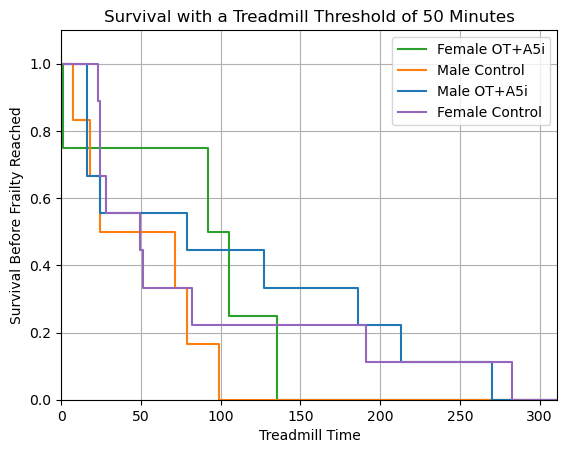

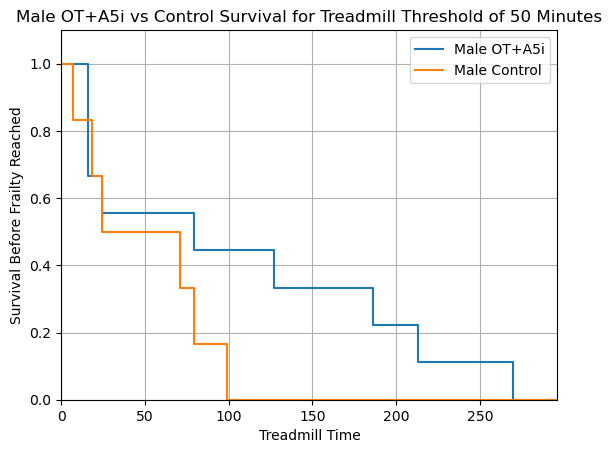

Male OT+A5i vs Control p-value = 0.1544085174541682


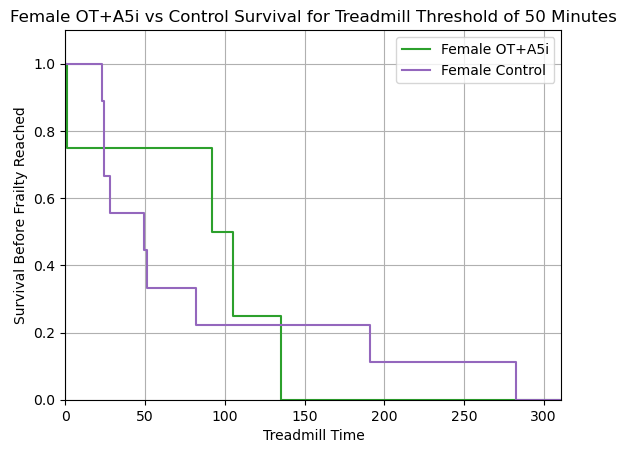

Female OT+A5i vs Control p-value = 0.9112777003300742


In [17]:
#Healthspan Graph for Specific Values
#When comparing to previous graphs, remember they were not done with div_factor for frailty index
threshold = 50
Name_Thresh = 'Treadmill Threshold of 50 Minutes'
Xaxis = 'Treadmill Time'
Normalized = 0
remove_0s = 0


if mice_death_before_lasthealth_indexes:
    print('ERROR THESE MICE HAVE DEATH DATES BEFORE THEIR LAST HEALTH CHECK: '+names_by_indexes(M_ID, mice_death_before_lasthealth_indexes))

Sep_Dates = healthspan_calc(threshold, Normalized,remove_0s)
print(Sep_Dates)

#Code to the backwards Kaplan Meier Plot for Threshold Death Count
Axis = {}
for cohort in GCohorts:
    Axis[cohort] = []
GCount = {}

for cohort in GCohorts:
    Sep_Dates[cohort] = [i for i in Sep_Dates[cohort] if (i != 0)]
    for index, thresh in enumerate(Sep_Dates[cohort]):
        Axis[cohort].append((index)/len(Sep_Dates[cohort]))
    print(cohort+' average '+str((sum(Sep_Dates[cohort])/len(Sep_Dates[cohort]))))
    GCount[cohort] = Sep_Dates[cohort] + [min(FI_values)-1000] + [max(FI_values)+1000]
    Axis[cohort] = Axis[cohort] +[1]+ [-0.1]
    
#Sort based on higher is frail
for cohort in GCohorts:
    GCount[cohort].sort()
    Axis[cohort].sort(reverse=True)
xaxis_limit_list = []
for cohort in GCohorts:
    xaxis_limit_list += Sep_Dates[cohort]
    if not Sep_Dates[cohort]:
        plt.step([min(FI_values)-1,max(FI_values)+1],[1,1.1], where='post', label=Label_Dic[cohort], color=color_dict[cohort])
    else:
        plt.step(GCount[cohort], Axis[cohort], where ='post', label=Label_Dic[cohort], color=color_dict[cohort])
xlen = max(xaxis_limit_list) - min(xaxis_limit_list)
plt.xlim(left = 0, right=max(xaxis_limit_list)+0.1*xlen)
plt.ylim(top=1.1, bottom=0)

plt.xlabel(Xaxis)
plt.ylabel('Survival Before Frailty Reached')
plt.title('Survival with a '+Name_Thresh)
plt.grid(True)
plt.legend()
plt.show()

for key, value in Test_Cohorts.items():
    xaxis_limit_list = []
    for cohort in value:
        xaxis_limit_list += Sep_Dates[cohort]
        if not Sep_Dates[cohort]:
            plt.step([min(FI_values)-1,max(FI_values)+1],[1,1.1], where='post', label=Label_Dic[cohort], color=color_dict[cohort])
        else:
            plt.step(GCount[cohort], Axis[cohort], where ='post', label=Label_Dic[cohort], color=color_dict[cohort])
    xlen = max(xaxis_limit_list) - min(xaxis_limit_list)
    plt.xlim(left = 0, right=max(xaxis_limit_list)+0.1*xlen)
    plt.ylim(top=1.1, bottom=0)
    
    plt.xlabel(Xaxis)
    plt.ylabel('Survival Before Frailty Reached')
    plt.title(key+' Survival for '+Name_Thresh)
    plt.grid(True)
    plt.legend()
    plt.show()
    print(key+" p-value = "+str(logrank_test(Sep_Dates[value[0]], Sep_Dates[value[1]]).p_value))
    

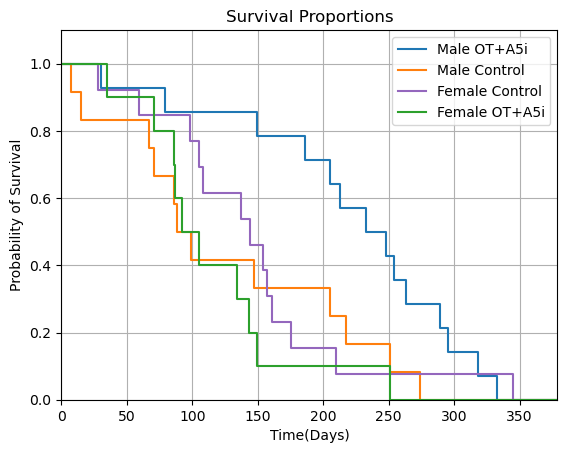

2.0


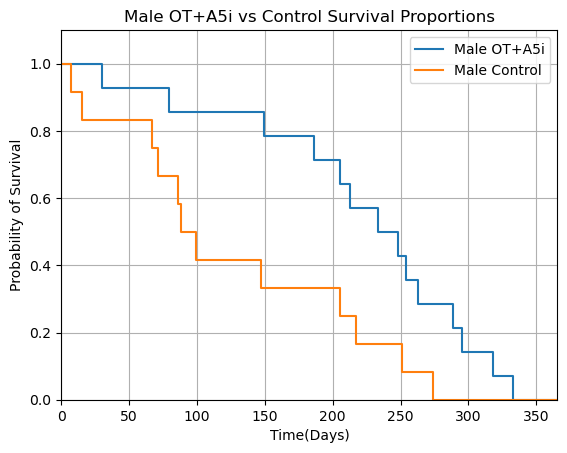

Male OT+A5i vs Control p-value = 0.012517895990837373
Average lifespans:  MOA 221.07142857142858 MCL 127.25 Ratio: 1.7373000280662365
Median lifespans:  MOA 240.5 MCL 93.5 Ratio: 2.572192513368984
Hazard Ratio of MCL to MOA: 2.8683005782224584


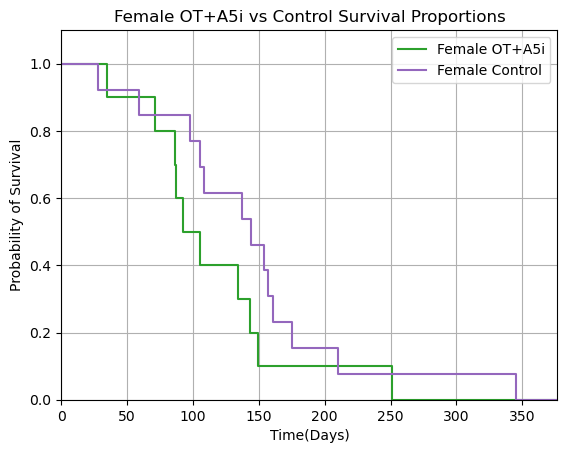

Female OT+A5i vs Control p-value = 0.1903508051253064
Average lifespans:  FOA 115.3 FCL 144.69230769230768 Ratio: 1.2549202748682367
Median lifespans:  FOA 98.5 FCL 144 Ratio: 1.4619289340101522
Hazard Ratio of FCL to FOA: 0.5662904727589134


In [10]:
#Lifespan Graph Below
dt = pd.read_excel (r'Dates 10.8.24.xlsx', sheet_name='Dates', header = None)
Test_Cohorts = {'Male OT+A5i vs Control': ['MOA','MCL'], 'Female OT+A5i vs Control': ['FOA','FCL']}
start_from_inj = 1
left_lim = 0
#{'Male XBP1s': ['MXOA', 'MXCL'], 'Female XBP1s': ['FXOA','FXCL'], 'Male XBP1s vs Control': ['MXCL','MCL'], 'Female XBP1s vs Control': ['FXCL','FCL']}
#{'Male OT+A5i vs Control': ['MOA','MCL'], 'Female OT+A5i vs Control': ['FOA','FCL']}
#                , 'Male XBP1s': ['MXOA', 'MXCL']}


Label_Dic = {'MOA': "Male OT+A5i", 'FOA': "Female OT+A5i", 'MCL': "Male Control", 'FCL': "Female Control", 'MXOA': "Male XBP1S OT+A5i", 'FXOA': "Female XBP1S OT+A5i", 'MXCL': "Male XBP1S Control", 'FXCL': "Female XBP1S Control",'MJ': "Male MPD Control",'FJ': "Female MPD Control"}
color_dict = {'MOA': [0.12156863, 0.46666667, 0.70588235, 1.        ], 'MCL': [1.        , 0.49803922, 0.05490196, 1.        ], 'FOA': [0.17254902, 0.62745098, 0.17254902, 1.        ], 'FCL': [0.58039216, 0.40392157, 0.74117647, 1.        ], 'MJ': [0.54901961, 0.3372549 , 0.29411765, 1.        ], 'FJ': 'red', 'F?': [0.09019608, 0.74509804, 0.81176471, 1.        ]}

GCohorts = []
for sublist in list(Test_Cohorts.values()):
    GCohorts.extend(sublist)
GCohorts = list(set(GCohorts))

DOB = dt.iloc[1:,5:6]
DOI = dt.iloc[1:,6:7]
DOD = dt.iloc[1:,4:5]
DOB = DOB[5].tolist()
DOI = DOI[6].tolist()
DOD = DOD[4].tolist()
Cohort = dt.iloc[1:,1:3]
Sex = dt.iloc[1:,1:2]
Comb_Cohort = Cohort[1] + Cohort[2]
Cohort = Comb_Cohort.values.tolist()

def numOfDays(date1, date2):
    return (date2-date1).days
date_dif = []
if start_from_inj == 1:
    for index, death in enumerate(DOD):
        if pd.isna(DOI[index]) or pd.isna(death) or isinstance(DOI[index], str) or isinstance(death, str):
            date_dif.append('unknown')
        else:
            if numOfDays(DOI[index], death) > 0:
                date_dif.append(numOfDays(DOI[index], death))
            else:
                date_dif.append(0)
else:
    for index, death in enumerate(DOD):
        if pd.isna(DOB[index]) or pd.isna(death) or isinstance(DOB[index], str) or isinstance(death, str):
            date_dif.append('unknown')
        else:
            if numOfDays(DOB[index], death) > 0:
                date_dif.append(numOfDays(DOB[index], death))
            else:
                date_dif.append(0)
Lifespan_Dates = {}
for cohort in GCohorts:
    Lifespan_Dates[cohort] = []
for index, date in enumerate(date_dif):
    assignment = Cohort[index]
    if assignment in GCohorts:
        Lifespan_Dates[assignment].append(date)

#Calculating the average lifespan and Hazard Ratio by Cox Proportional Hazards
def calculate_average_lifespan(lifespans):
    return sum(lifespans) / len(lifespans)
# Initialize the Cox proportional hazards model
cox_model = CoxPHFitter()

#Kaplan-Meier Code Plot
Axis = {}
for cohort in GCohorts:
    Axis[cohort] = []
GCount = {}

for cohort in GCohorts:
    Lifespan_Dates[cohort] = [i for i in Lifespan_Dates[cohort] if (i != 0)]
    for index, thresh in enumerate(Lifespan_Dates[cohort]):
        Axis[cohort].append((index)/len(Lifespan_Dates[cohort]))
    GCount[cohort] = Lifespan_Dates[cohort] + [min(Lifespan_Dates[cohort])-1000] + [max(Lifespan_Dates[cohort])+1000]
    Axis[cohort] = Axis[cohort] +[1]+ [-0.1]

def assign_colors(keys):
    num_keys = len(keys)
    # Generate evenly spaced colors in the RGB color space
    colors = plt.cm.tab10(np.linspace(0, 1, num_keys))
    color_dict = {}
    for i, key in enumerate(keys):
        color_dict[key] = colors[i]
    return color_dict
#color_dict = assign_colors(GCohorts)
  
#Sort based on higher is frail
for cohort in GCohorts:
    GCount[cohort].sort()
    Axis[cohort].sort(reverse=True)
        
xaxis_limit_list = []
for cohort in GCohorts:
    xaxis_limit_list += Lifespan_Dates[cohort]
    if not Lifespan_Dates[cohort]:
        plt.step([min(FI_values)-1,max(FI_values)+1],[1,1.1], where='post', label=Label_Dic[cohort], color=color_dict[cohort])
    else:
        plt.step(GCount[cohort], Axis[cohort], where ='post', label=Label_Dic[cohort], color=color_dict[cohort])
xlen = max(xaxis_limit_list) - min(xaxis_limit_list)
plt.xlim(left = left_lim, right=max(xaxis_limit_list)+0.1*xlen)
plt.ylim(top=1.1, bottom=0)

plt.xlabel('Time(Days)')
plt.ylabel('Probability of Survival')
plt.title('Survival Proportions')
plt.grid(True)
plt.legend()
plt.show()

def calculate_ratio(val1, val2):
    if val1 == 0 or val2 == 0:
        print("Division by zero is not allowed.")
    
    larger = max(val1, val2)
    smaller = min(val1, val2)
    
    return larger / smaller

# Example usage
ratio = calculate_ratio(10, 5)
print(ratio)  # Output: 2.0


for key, value in Test_Cohorts.items():
    xaxis_limit_list = []
    for cohort in value:
        xaxis_limit_list += Lifespan_Dates[cohort]
        if not Lifespan_Dates[cohort]:
            plt.step([min(FI_values)-1,max(FI_values)+1],[1,1.1], where='post', label=Label_Dic[cohort], color=color_dict[cohort])
        else:
            plt.step(GCount[cohort], Axis[cohort], where ='post', label=Label_Dic[cohort], color=color_dict[cohort])
    xlen = max(xaxis_limit_list) - min(xaxis_limit_list)
    plt.xlim(left = left_lim, right=max(xaxis_limit_list)+0.1*xlen)
    plt.ylim(top=1.1, bottom=0)
    
    plt.xlabel('Time(Days)')
    plt.ylabel('Probability of Survival')
    plt.title(key+' Survival Proportions')
    plt.grid(True)
    plt.legend()
    plt.show()
    print(key+" p-value = "+str(logrank_test(Lifespan_Dates[value[0]], Lifespan_Dates[value[1]]).p_value))
    print('Average lifespans: ',value[0],calculate_average_lifespan(Lifespan_Dates[value[0]]),value[1],calculate_average_lifespan(Lifespan_Dates[value[1]]), 'Ratio:', calculate_ratio(calculate_average_lifespan(Lifespan_Dates[value[0]]),calculate_average_lifespan(Lifespan_Dates[value[1]])))
    print('Median lifespans: ',value[0],statistics.median(Lifespan_Dates[value[0]]),value[1],statistics.median(Lifespan_Dates[value[1]]), 'Ratio:', calculate_ratio(statistics.median(Lifespan_Dates[value[0]]),statistics.median(Lifespan_Dates[value[1]])))
    # Hazard Ratio - Combine both groups into a single dataset
    data = {
        'lifespan': Lifespan_Dates[value[0]] + Lifespan_Dates[value[1]],
        'treatment': [0] * len(Lifespan_Dates[value[0]]) + [1] * len(Lifespan_Dates[value[1]])}
    
    # Convert the data into a pandas DataFrame
    df = pd.DataFrame(data)
    # Fit the Cox model to the combined data, with 'group' as a covariate
    cox_model.fit(df, duration_col='lifespan')
    
    # Calculate the hazard ratio between the two groups
    hazard_ratio = cox_model.hazard_ratios_['treatment']
    print('Hazard Ratio of '+str(value[1])+' to '+str(value[0])+': '+str(hazard_ratio))
